In [1]:
# !pip install pandas==0.25.3
# !pip install numpy==1.17.3
# !pip install Keras==2.3.1
# !pip install tensorflow==2.11.0
# !pip install tqdm==4.43.0
# !pip install matplotlib==3.1.3

In [2]:
import re
import os
import numpy as np 
import pandas as pd
from tqdm import tqdm

# Drawing the embeddings
import matplotlib.pyplot as plt

# Deep learning: 
import tensorflow as tf
from scipy import sparse

### Create Dataset

In [3]:
texts = [
    'The future king is the prince',
    'Daughter is the princess',
    'Son is the prince',
    'Only a man can be a king',
    'Only a woman can be a queen',
    'The princess will be a queen',
    'Queen and king rule the realm',
    'The prince is a strong man',
    'The princess is a beautiful woman',
    'The royal family is the king and queen and their children',
    'Prince is only a boy now',
    'A boy will be a man',
]

### Utility functions

In [4]:
def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict    

def text_preprocessing(
    text:list,
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will']
    )->list:
    """
    A method to preproces text
    """
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x!='']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

# Functions to find the most similar word 
def euclidean(vec1:np.array, vec2:np.array) -> float:
    """
    A function to calculate the euclidean distance between two vectors
    """
    return np.sqrt(np.sum((vec1 - vec2)**2))

def find_similar(word:str, embedding_dict:dict, top_n=10)->list:
    """
    A method to find the most similar word based on the learnt embeddings
    """
    dist_dict = {}
    word_vector = embedding_dict.get(word, [])
    if len(word_vector) > 0:
        for key, value in embedding_dict.items():
            if key!=word:
                dist = euclidean(word_vector, value)
                dist_dict.update({
                    key: dist
                })

        return sorted(dist_dict.items(), key=lambda x: x[1])[0:top_n]   

### Preprocess Data

In [5]:
# Reading the text from the input folder
print(texts)
texts = [x for x in texts]

# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in texts:
    print("Text before preprocessing: ", text)
    # Cleaning the text
    text = text_preprocessing(text)
    print("Text after preprocessing: ", text)
    print(text)
    # Appending to the all text list
    all_text += text 

    # Creating a context dictionary
    for i, word in enumerate(text):
        print(".......i.......", i, ".......word.......", word)

        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

print("word lists: ", word_lists)
unique_word_dict = create_unique_word_dict(all_text)
print("unique word dict", unique_word_dict)

# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])
    print(".....i.....", i, ".....word_list.....", word_list, ".....word_list[0]: ", word_list[0], " || word_list[1]: ", word_list[1],".....")

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
# X = sparse.csr_matrix(X)
# Y = sparse.csr_matrix(Y)
X = np.array(X)
Y = np.array(Y)
print(X)
print(Y)

84it [00:00, 28380.98it/s]

['The future king is the prince', 'Daughter is the princess', 'Son is the prince', 'Only a man can be a king', 'Only a woman can be a queen', 'The princess will be a queen', 'Queen and king rule the realm', 'The prince is a strong man', 'The princess is a beautiful woman', 'The royal family is the king and queen and their children', 'Prince is only a boy now', 'A boy will be a man']
Text before preprocessing:  The future king is the prince
Text after preprocessing:  ['future', 'king', 'prince']
['future', 'king', 'prince']
.......i....... 0 .......word....... future
.......i....... 1 .......word....... king
.......i....... 2 .......word....... prince
Text before preprocessing:  Daughter is the princess
Text after preprocessing:  ['daughter', 'princess']
['daughter', 'princess']
.......i....... 0 .......word....... daughter
.......i....... 1 .......word....... princess
Text before preprocessing:  Son is the prince
Text after preprocessing:  ['son', 'prince']
['son', 'prince']
.......i..

### Create Embeddings

In [6]:
Y.shape

(84, 21)

In [12]:
# Defining the size of the embedding
embed_size = 2

# Defining the neural network
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(units=embed_size, activation='linear'),
    tf.keras.layers.Dense(units=Y.shape[1], activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='nadam')

# Optimizing the network weights
model.fit(x=X, y=Y, batch_size=16, epochs=50)

# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })
print(embedding_dict)

Epoch 1/50
6/6 [==============================] - 1s 2ms/step - loss: 3.0713
Epoch 2/50
6/6 [==============================] - 0s 2ms/step - loss: 3.0689
Epoch 3/50
6/6 [==============================] - 0s 2ms/step - loss: 3.0661
Epoch 4/50
6/6 [==============================] - 0s 2ms/step - loss: 3.0633
Epoch 5/50
6/6 [==============================] - 0s 2ms/step - loss: 3.0604
Epoch 6/50
6/6 [==============================] - 0s 2ms/step - loss: 3.0575
Epoch 7/50
6/6 [==============================] - 0s 2ms/step - loss: 3.0544
Epoch 8/50
6/6 [==============================] - 0s 2ms/step - loss: 3.0516
Epoch 9/50
6/6 [==============================] - 0s 3ms/step - loss: 3.0488
Epoch 10/50
6/6 [==============================] - 0s 2ms/step - loss: 3.0460
Epoch 11/50
6/6 [==============================] - 0s 2ms/step - loss: 3.0433
Epoch 12/50
6/6 [==============================] - 0s 2ms/step - loss: 3.0410
Epoch 13/50
6/6 [==============================] - 0s 2ms/step - loss: 3.

### Visualize the embeddings

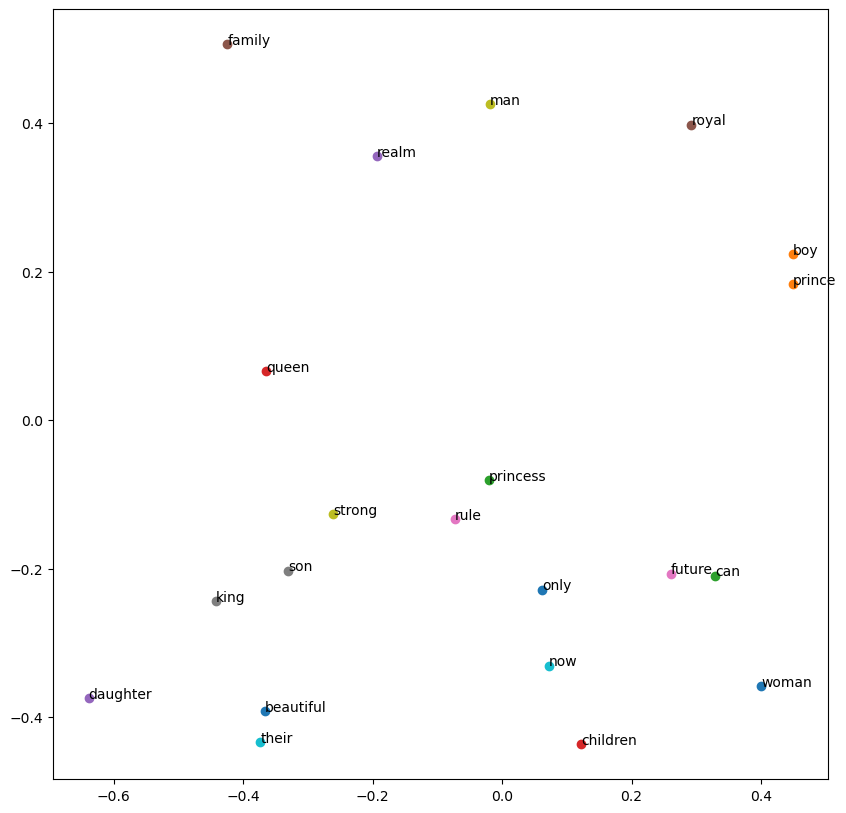

In [13]:
# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()): 
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))   